In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# command to make plots appear inside the notebook
%matplotlib inline

print("Libraries imported successfully!")

Libraries imported successfully!


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

%matplotlib inline

def process_repeat_file(filename, chromosome_name, window_size=50000):
    """
    Reads a RepeatMasker .out file and counts repeat types in genomic windows.
    Handles both 16 and 17-column UCSC formats.
    """
    print(f"Processing {filename}...")
    
    # Define the 17 column names (for Human, Mouse, Chicken)
    col_names_17 = [
        "bin", "SW_score", "perc_div", "perc_del", "perc_ins", "query_seq", 
        "query_begin", "query_end", "query_left", "strand", "repeat_name", 
        "repeat_class", "repeat_family", "repeat_pos_begin", "repeat_pos_end", "repeat_pos_left", "id"
    ]
    
    # Define the 16 column names (for Chimp)
    col_names_16 = [
        "bin", "SW_score", "perc_div", "perc_del", "perc_ins", "query_seq", 
        "query_begin", "query_end", "query_left", "strand", "repeat_name", 
        "repeat_class", "repeat_pos_begin", "repeat_pos_end", "repeat_pos_left", "id"
    ]
    
    # Define which columns we always want to load
    use_cols = ["query_seq", "query_begin", "query_end", "repeat_class"]

    # Read the file. 
    try:
        # First, try to read it as a 17-column file
        df = pd.read_csv(
            filename, 
            header=None,
            names=col_names_17, 
            usecols=use_cols,
            sep='\s+',
            low_memory=False
        )
    except ValueError as e:
        # If that fails (due to column mismatch), try 16 columns
        print(f"Trying 16-column format for {filename}...")
        try:
            df = pd.read_csv(
                filename, 
                header=None,
                names=col_names_16, 
                usecols=use_cols,
                sep='\s+',
                low_memory=False
            )
        except Exception as e_inner:
            print(f"FATAL Error reading {filename} on both attempts: {e_inner}")
            return None
    except Exception as e:
        print(f"FATAL Error reading {filename}: {e}")
        return None

    # --- Data Cleaning ---
    # --- NEW FIX ---
    # Auto-detect the main chromosome (most common entry in 'query_seq')
    # This avoids issues where the name isn't exactly 'chr22'
    try:
        main_chromosome_name = df["query_seq"].mode()[0]
        print(f"  > Auto-detected main chromosome: {main_chromosome_name}")
        # Filter for this main chromosome, removing '_random' contigs etc.
        df = df[df["query_seq"] == main_chromosome_name].copy()
    except Exception as e:
        print(f"  > WARNING: Could not auto-detect main chromosome. Using all contigs. Error: {e}")
    # --- END NEW FIX ---
    
    # Force columns to be numeric. errors='coerce' turns bad data into NaN
    df["query_begin"] = pd.to_numeric(df["query_begin"], errors='coerce')
    df["query_end"] = pd.to_numeric(df["query_end"], errors='coerce')

    # Drop any rows that had bad data (e.g., text headers)
    df = df.dropna(subset=["query_begin", "query_end"])
    
    # Calculate the length of each repeat
    df["repeat_length"] = df["query_end"] - df["query_begin"]
    
    # Simplify repeat classes (e.g., "SINE/Alu" -> "SINE")
    df["repeat_class"] = df["repeat_class"].apply(lambda x: str(x).split('/')[0])
    
    # Get the total length of the chromosome
    max_length = df["query_end"].max()
    
    # --- Feature Engineering (The "Windowing") ---
    windows = []
    
    # Loop from base 0 to the end of the chromosome, one window at a time
    for i in range(0, int(max_length), window_size):
        win_start = i
        win_end = i + window_size
        
        # Create a name for this window
        window_id = f"{chromosome_name}_{win_start}_{win_end}"
        
        # Grab all repeats that fall inside this window
        window_df = df[(df["query_begin"] >= win_start) & (df["query_end"] < win_end)]
        
        # Now, pivot and count
        counts = window_df.groupby("repeat_class")["repeat_length"].sum()
        
        # Create a dictionary to hold our new features
        features = {
            "window_id": window_id,
            "SINE": counts.get("SINE", 0),
            "LINE": counts.get("LINE", 0),
            "LTR": counts.get("LTR", 0),
            "DNA": counts.get("DNA", 0), 
            "Simple_repeat": counts.get("Simple_repeat", 0),
            "Other": counts.get("Unknown", 0) + counts.get("Other", 0) + counts.get("Satellite", 0) + counts.get("Low_complexity", 0)
        }
        
        # Calculate percentages
        total_repeats_in_window = (
            features["SINE"] + features["LINE"] + features["LTR"] +
            features["DNA"] + features["Simple_repeat"] + features["Other"]
        )
        features["Total_Repeat_Percent"] = total_repeats_in_window / window_size
        
        windows.append(features)

    print(f"Finished {filename}. Created {len(windows)} windows.")
    return pd.DataFrame(windows)

In [27]:
# --- Run the processing ---
# Note: These filenames must match what's in your folder!

# Project 1: Disease
df_human = process_repeat_file("human_chr22.out", "chr22")

# Project 2: Evolution
df_chimp = process_repeat_file("chimp_chr22.out", "chr22")
df_mouse = process_repeat_file("mouse_chr10.out", "chr10")
df_chicken = process_repeat_file("chicken_chr20.out", "chr20")

print("\n--- All files processed! ---")

Processing human_chr22.out...
  > Auto-detected main chromosome: chr22
Finished human_chr22.out. Created 1017 windows.
Processing chimp_chr22.out...
Trying 16-column format for chimp_chr22.out...
  > Auto-detected main chromosome: 14583680
Finished chimp_chr22.out. Created 292 windows.
Processing mouse_chr10.out...
  > Auto-detected main chromosome: chr10
Finished mouse_chr10.out. Created 2609 windows.
Processing chicken_chr20.out...
  > Auto-detected main chromosome: chr20
Finished chicken_chr20.out. Created 278 windows.

--- All files processed! ---


In [29]:
df_human.head()

,window_id,SINE,LINE,LTR,DNA,Simple_repeat,Other,Total_Repeat_Percent
0,chr22_0_50000,0,0,0,0,0,0,0.0
1,chr22_50000_100000,0,0,0,0,0,0,0.0
2,chr22_100000_150000,0,0,0,0,0,0,0.0
3,chr22_150000_200000,0,0,0,0,0,0,0.0
4,chr22_200000_250000,0,0,0,0,0,0,0.0


In [30]:
df_human.sample(10)

,window_id,SINE,LINE,LTR,DNA,Simple_repeat,Other,Total_Repeat_Percent
766,chr22_38300000_38350000,20868,4736,0,880,663,70,0.54434
726,chr22_36300000_36350000,8552,1800,41,1165,252,52,0.23724
151,chr22_7550000_7600000,0,0,0,0,0,0,0.00000
376,chr22_18800000_18850000,7895,5264,1393,934,298,120,0.31808
721,chr22_36050000_36100000,23085,9140,3809,1997,1282,123,0.78872
240,chr22_12000000_12050000,895,10718,359,1569,328,494,0.28726
529,chr22_26450000_26500000,9873,7654,364,738,338,0,0.37934
948,chr22_47400000_47450000,6079,10860,8858,372,316,194,0.53358
89,chr22_4450000_4500000,0,0,0,0,0,0,0.00000
395,chr22_19750000_19800000,4874,7465,1524,201,514,179,0.29514


In [31]:
import pandas as pd # Re-importing pandas just in case, good practice in new cells

print("Loading GWAS (disease) data...")
# Load the GWAS BED file. It has no header, we only need the start/end columns
try:
    gwas_df = pd.read_csv(
        "gwas_chr22.bed", 
        sep='\t', 
        header=None, 
        usecols=[1, 2], # Column 1 is start, Column 2 is end
        names=["gwas_start", "gwas_end"]
    )
    print(f"Successfully loaded {len(gwas_df)} GWAS sites.")

    # Convert our df_human window_id into start/end columns for comparison
    # This splits 'chr22_0_50000' into 0 and 50000
    df_human['win_start'] = df_human['window_id'].apply(lambda x: int(x.split('_')[1]))
    df_human['win_end'] = df_human['window_id'].apply(lambda x: int(x.split('_')[2]))

    # Create the new 'is_disease_associated' column, default to 0 (normal)
    df_human['is_disease_associated'] = 0

    # This is a fast way to check for overlaps
    # We iterate through each GWAS site
    for index, gwas_row in gwas_df.iterrows():
        gwas_start = gwas_row['gwas_start']
        
        # Find all windows that this one GWAS site overlaps
        overlapping_windows = (df_human['win_start'] <= gwas_start) & (df_human['win_end'] > gwas_start)
        
        # Set the 'is_disease_associated' flag for those windows to 1
        df_human.loc[overlapping_windows, 'is_disease_associated'] = 1

    print("\n--- Labeling complete! ---")
    
    # Check our results
    label_counts = df_human['is_disease_associated'].value_counts()
    print(f"Label counts:\n{label_counts}")
    
    # Display the table again, now with the new columns
    df_human.sample(10)

except FileNotFoundError:
    print("\n--- ERROR ---")
    print("Could not find the 'gwas_chr22.bed' file.")
    print("Please make sure you downloaded it from UCSC and unzipped it in the same folder.")
except Exception as e:
    print(f"An error occurred: {e}")

Loading GWAS (disease) data...
Successfully loaded 10848 GWAS sites.

--- Labeling complete! ---
Label counts:
is_disease_associated
1    645
0    372
Name: count, dtype: int64


In [32]:
#Disease Model

In [33]:
# --- Step 7: Build and Train the Disease Model ---

# 1. Define your features (X) and your target (y)
# X = all the repeat columns
features = ['SINE', 'LINE', 'LTR', 'DNA', 'Simple_repeat', 'Other', 'Total_Repeat_Percent']
X = df_human[features]
# y = the single column we want to predict
y = df_human['is_disease_associated']

# 2. Split the data: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training on {len(X_train)} windows...")
print(f"Testing on {len(X_test)} windows...")

# 3. Create and train the Random Forest model
# n_estimators=100 means it builds 100 "decision trees"
# random_state=42 ensures you get the same result every time you run it
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 4. Make predictions on the hidden "test" data
y_pred = rf_model.predict(X_test)

# 5. Calculate and print the accuracy!
accuracy = accuracy_score(y_test, y_pred)

print("\n--- Model Training Complete! ---")
print(f"\nModel Accuracy: {accuracy * 100:.2f}%")

Training on 813 windows...
Testing on 204 windows...

--- Model Training Complete! ---

Model Accuracy: 88.24%


--- Feature Importance ---
This chart shows which repeat types were the MOST important
for the model's predictions.

                Feature  Importance
0                  SINE    0.285795
4         Simple_repeat    0.165620
3                   DNA    0.144020
1                  LINE    0.139474
6  Total_Repeat_Percent    0.138953
5                 Other    0.079121
2                   LTR    0.047017


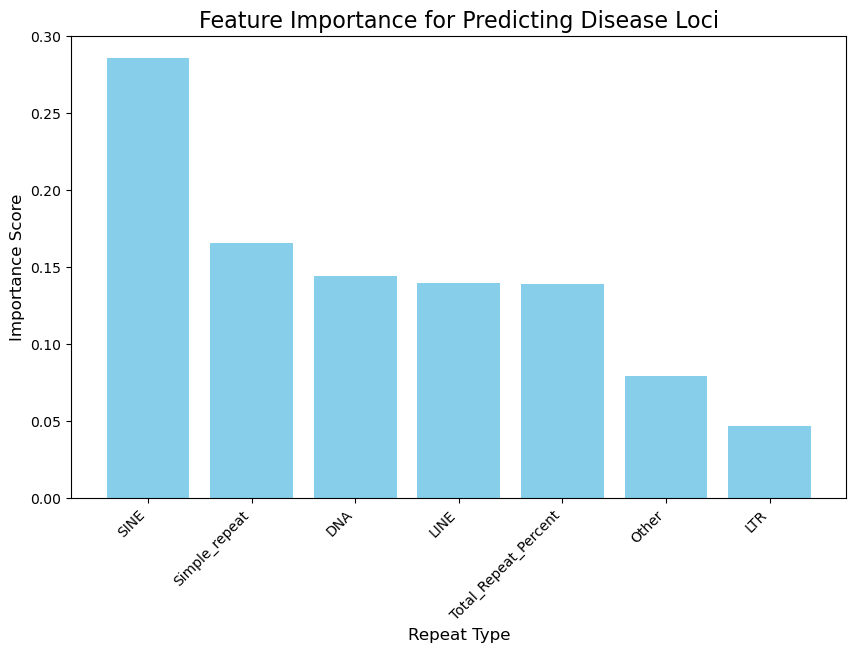

In [38]:
# --- Step 8 (Updated): Get AND SAVE Model Insight ---

print("--- Feature Importance ---")
print("This chart shows which repeat types were the MOST important")
print("for the model's predictions.\n")

# Get the importance scores from the model
importances = rf_model.feature_importances_
# Get the names of the features
feature_names = X.columns

# Create a new DataFrame to hold the results
feature_importance_df = pd.DataFrame(
    {'Feature': feature_names, 'Importance': importances}
)

# Sort the features by importance (most important on top)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the table
print(feature_importance_df)

# --- Create the Bar Chart ---
plt.figure(figsize=(10, 6)) # Set the size of the plot
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.title('Feature Importance for Predicting Disease Loci', fontsize=16)
plt.xlabel('Repeat Type', fontsize=12)
plt.ylabel('Importance Score', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability

# --- NEW LINE TO SAVE THE PLOT ---
# This saves the plot as a PNG file before showing it
# dpi=300 makes it high-resolution for your presentation
plt.savefig('disease_importance.png', dpi=300, bbox_inches='tight')
# --- END NEW LINE ---

plt.show()

In [35]:
# --- Step 9: Prepare Data for Evolution Project ---

# 1. Add 'species' labels to our dataframes
# We'll use just the feature columns we need
feature_cols = ['SINE', 'LINE', 'LTR', 'DNA', 'Simple_repeat', 'Other', 'Total_Repeat_Percent']

# Make copies to avoid any data mix-ups
human_evo_df = df_human[feature_cols].copy()
human_evo_df['species'] = 'Human'

mouse_evo_df = df_mouse[feature_cols].copy()
mouse_evo_df['species'] = 'Mouse'

chicken_evo_df = df_chicken[feature_cols].copy()
chicken_evo_df['species'] = 'Chicken'

# 2. Combine them into one big table
evolution_df = pd.concat([human_evo_df, mouse_evo_df, chicken_evo_df])

# 3. Check the new combined table
print(f"Created a new dataset with {len(evolution_df)} total windows.")
print("Here's a random sample:")
evolution_df.sample(10)

Created a new dataset with 3904 total windows.
Here's a random sample:


,SINE,LINE,LTR,DNA,Simple_repeat,Other,Total_Repeat_Percent,species
489,1548,3503,4906,778,2134,330,0.26398,Mouse
422,9385,6659,1056,861,470,36,0.36934,Human
273,382,744,0,127,423,57,0.03466,Chicken
2204,1758,16678,1273,1480,1112,196,0.44994,Mouse
1833,1318,13390,6814,677,1040,97,0.46672,Mouse
2062,2869,16157,7003,0,1864,181,0.56148,Mouse
865,6004,2459,661,1380,424,124,0.22104,Human
1696,4213,5174,1542,396,866,257,0.24896,Mouse
2047,1914,5888,2888,1441,1370,337,0.27676,Mouse
77,0,1357,5751,365,382,54,0.15818,Chicken


In [36]:
# --- Step 10: Build and Train the Evolution Model ---

# 1. Define your features (X) and your target (y)
X_evo = evolution_df[features] # features is the same list from before
y_evo = evolution_df['species']

# 2. Split the data
X_train_evo, X_test_evo, y_train_evo, y_test_evo = train_test_split(
    X_evo, y_evo, test_size=0.2, random_state=42
)

print(f"Training on {len(X_train_evo)} windows...")
print(f"Testing on {len(X_test_evo)} windows...")

# 3. Create and train the Random Forest model
evo_model = RandomForestClassifier(n_estimators=100, random_state=42)
evo_model.fit(X_train_evo, y_train_evo)

# 4. Make predictions and get the accuracy
y_pred_evo = evo_model.predict(X_test_evo)
evo_accuracy = accuracy_score(y_test_evo, y_pred_evo)

print("\n--- Evolution Model Training Complete! ---")
print(f"\nModel Accuracy: {evo_accuracy * 100:.2f}%")

Training on 3123 windows...
Testing on 781 windows...

--- Evolution Model Training Complete! ---

Model Accuracy: 94.49%


Creating PCA plot...


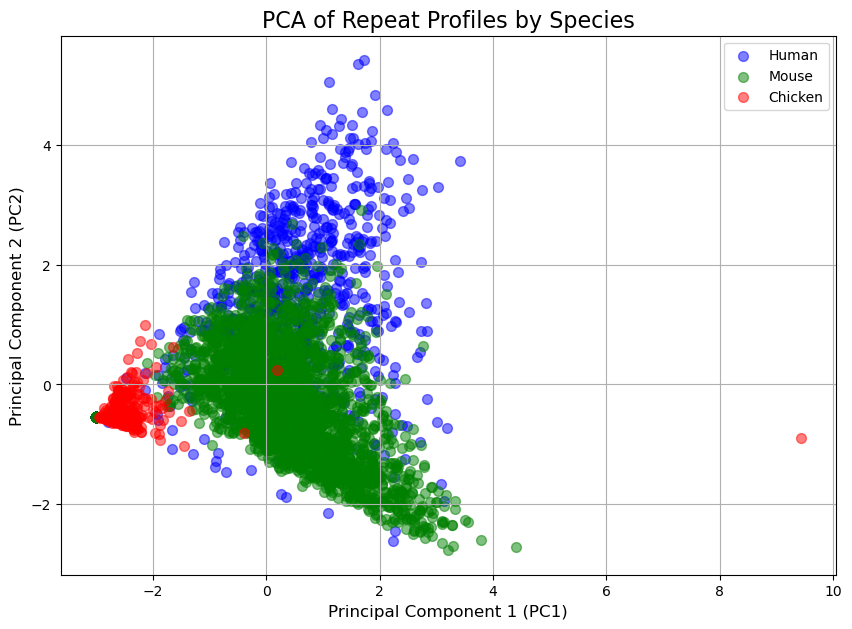

In [39]:
# --- Step 11 (Updated): Create AND SAVE the PCA Plot ---

print("Creating PCA plot...")

# 1. Standardize the data
X_scaled = StandardScaler().fit_transform(X_evo)

# 2. Run PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 3. Put the results into a new DataFrame
pca_df = pd.DataFrame(
    data = X_pca, 
    columns = ['PC1', 'PC2']
)
pca_df['species'] = y_evo.values

# 4. Create the scatter plot
plt.figure(figsize=(10, 7))
targets = ['Human', 'Mouse', 'Chicken']
colors = ['blue', 'green', 'red']

for target, color in zip(targets, colors):
    indices_to_keep = pca_df['species'] == target
    plt.scatter(
        pca_df.loc[indices_to_keep, 'PC1'],
        pca_df.loc[indices_to_keep, 'PC2'],
        c = color,
        s = 50,
        label = target,
        alpha = 0.5
    )

plt.title('PCA of Repeat Profiles by Species', fontsize=16)
plt.xlabel('Principal Component 1 (PC1)', fontsize=12)
plt.ylabel('Principal Component 2 (PC2)', fontsize=12)
plt.legend()
plt.grid()

# --- NEW LINE TO SAVE THE PLOT ---
# This saves the plot as a PNG file before showing it
plt.savefig('evolution_pca.png', dpi=300)
# --- END NEW LINE ---

plt.show()